In [415]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import randint as sp_randint
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

def load_dataset(path="data/rent-ideal.csv"):
    dataset = np.loadtxt(path, delimiter=",", skiprows=1)
    y = dataset[:, -1]
    X = dataset[:, 0:- 1]
    return X, y

def gradient_boosting_mse(X, y, num_iter, max_depth=1, nu=0.1):
    """Given predictors X, an array y, and num_iter (big M in the sum)
    
    Set random_state = 0 in your DecisionTreeRegressor() trees.

    Return the y_mean and trees 
   
    Input: X, y, num_iter
           max_depth
           nu (shrinkage parameter)

    Outputs:y_mean, array of trees from DecisionTreeRegressor 
    """
    trees = []
    N, _ = X.shape
    y_mean = np.mean(y)
    fm = y_mean*np.ones(N)
    #import pdb;pdb.set_trace()
    for iteration in range(0,num_iter):
        residuals = y - fm
        tree = DecisionTreeRegressor(random_state = 0,max_depth = max_depth)
        tree.fit(X,residuals)
        fm = fm + nu*tree.predict(X)
        trees.append(tree)
       # residuals = y - 
        
    ### BEGIN SOLUTION

    ### END SOLUTION
    return y_mean, trees  

def gradient_boosting_predict(X, trees, y_mean,  nu=0.1):
    """
    Given X, trees, y_mean predict y_hat
    """
    y_hat = y_mean
    for tree in trees:
        pred = tree.predict(X)
        y_hat = y_hat + nu*pred
    return y_hat

In [311]:
X,y = load_dataset('data/tiny.rent.train')

In [144]:
X_train, y_train = load_dataset("data/tiny.rent.train")
X_val, y_val = load_dataset("data/tiny.rent.test")


2. Set the learning rate to 0.1. Apply gradient boosting to your dataset using different values
for numTrees. How do you find the best value for numTrees? Report the train and
validation R2 for the best value of numTrees. Make a figure which summarizes your
experiment by plotting training and validation R2 as a function of the number of trees. Try
at least 2000 trees.

In [315]:
def func(X_train,y_train,X_val,y_val,num_of_trees):
    train_r2_score = []
    val_r2_score = []
    for num_iter in num_of_trees:
       # import pdb;pdb.set_trace()
        y_mean,trees = gradient_boosting_mse(X_train, y_train, num_iter, max_depth=1, nu=0.1)
        train_y_hat = gradient_boosting_predict(X_train, trees, y_mean,  nu=0.1)
        train_r2_score.append(r2_score(y_train, train_y_hat))
        val_y_hat = gradient_boosting_predict(X_val, trees, y_mean,  nu=0.1)
        val_r2_score.append(r2_score(y_val, val_y_hat))
    return train_r2_score,val_r2_score

In [318]:
df = pd.read_csv('data/rent-ideal.csv')
X = df[['bedrooms','bathrooms','latitude','longitude']]
y = df['price']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

In [319]:
num_of_trees = [1,50,100,150,200,500,1000,1500,2000]
train_r2_score,val_r2_score = func(X_train,y_train,X_val,y_val,num_of_trees)

In [320]:
print("The model with highest validation accuracy({:.2%}) has {} trees with {:.2%} training accuracy.".format(
    val_r2_score[np.argmax(val_r2_score)],num_of_trees[np.argmax(val_r2_score)],train_r2_score[np.argmax(val_r2_score)]))

The model with highest validation accuracy(67.74%) has 2000 trees with 68.61% training accuracy.


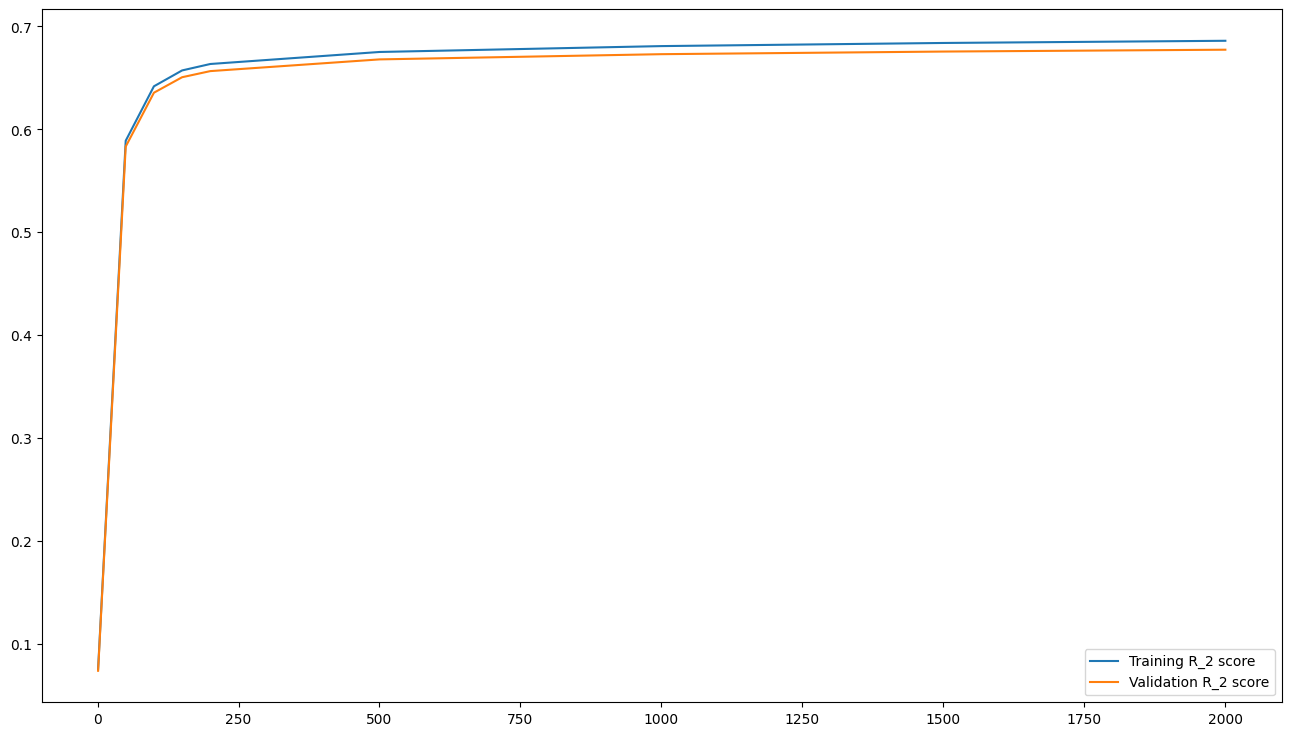

In [321]:
fig,axes = plt.subplots(figsize = (16,9));
axes.plot(pd.Series(num_of_trees),pd.Series(train_r2_score),label = 'Training R_2 score');
axes.plot(pd.Series(num_of_trees),pd.Series(val_r2_score),label = 'Validation R_2 score');
axes.legend();

3. Compare your results with the results of running the gradient boosting package XGBoost.
Explore the hyperparameters given in the package. Make plots or tables which illustrate
your tuning process and the results of your experiments.

In [193]:
import xgboost
from xgboost import XGBRegressor
model = XGBRegressor()

The various parameters involved in XGBoost Regressor are as follows:-<br>
    1. n_estimators: The number of trees in the ensemble, often increased until no further improvements are seen.<br>
    2. max_depth: The maximum depth of each tree, often values are between 1 and 10.<br>
    3. eta: The learning rate used to weight each model, often set to small values such as 0.3, 0.1, 0.01, or smaller.<br>
    4. subsample: The number of samples (rows) used in each tree, set to a value between 0 and 1, often 1.0 to use all samples.<br>
    5. colsample_bytree: Number of features (columns) used in each tree, set to a value between 0 and 1, often 1.0 to use all features.<br>

Since XGBoost can take a long time to train especially for trees with higher depth and n_estimators, 
we use BayesianSearchCV over RandomizedSearchCV and GridSearchCV. Unlike the grid search and random search, which treat hyperparameter sets independently, the Bayesian optimization is an informed search method, meaning that it learns from previous iterations.


In [322]:
from skopt import BayesSearchCV
from sklearn.model_selection import RandomizedSearchCV
from skopt.space import Real, Categorical, Integer

In [368]:
opt = BayesSearchCV(XGBRegressor(),{'n_estimators': Integer(1,1000),\
                                    'max_depth': Integer(1,8),\
                                    'eta': Real(0.01,1),\
                                    'subsample': Real(0.5,1),\
                                   'colsample_bytree':Real(0.5,1)},\
                    n_iter= 50,random_state=0,n_jobs=-1)

In [369]:
_ = opt.fit(X_train, y_train)

In [384]:
r2_score(y_test,opt.predict(X_val))

0.8539498896445783

The R2 obtained on the validation set as above is 85.4%.

In [385]:
opt.best_params_

OrderedDict([('colsample_bytree', 1.0),
             ('eta', 0.11985707181616058),
             ('max_depth', 8),
             ('n_estimators', 1000),
             ('subsample', 0.5)])

The best parameters that are <br>
eta: 0.12<br>
max_depth: 8 <br>
n_estimators: 1000<br>
sub_sample: 0.5<br>
colsample_by_tree: 1<br>

Now we know that Bayesian Search CV does not take every parameter into consideration, it converts the dataset into a 
into a K fold splitting process. we can look at each of the hyperparameters that the model selected.

In [381]:
cv_results = pd.DataFrame(opt.cv_results_)

In [411]:
cv_results = cv_results[cv_results['mean_test_score']>0]

**ETA**

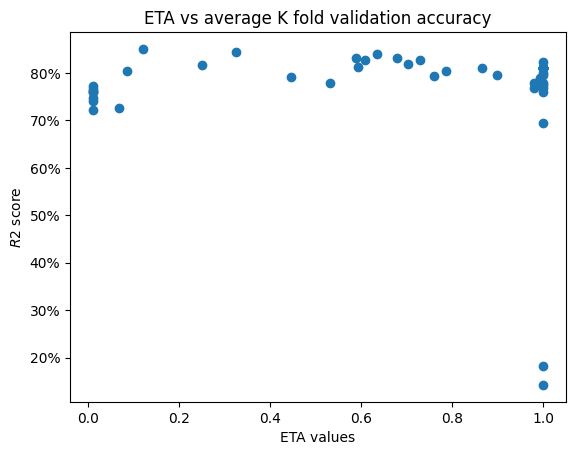

In [417]:
fig,axes = plt.subplots()
axes.scatter(cv_results['param_eta'],cv_results['mean_test_score']);
axes.set_title("ETA vs average K fold validation accuracy");
vals = axes.get_yticks();
axes.set_yticklabels(['{:,.0%}'.format(x) for x in vals]);
axes.set_ylabel('$R2$ score');
axes.set_xlabel('ETA values');

**Col Sample by Tree**

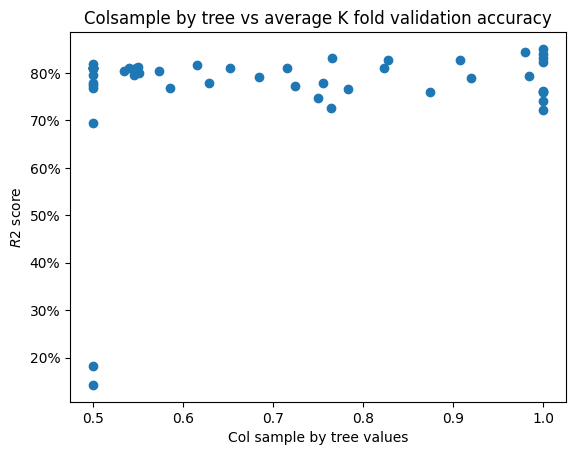

In [416]:
fig,axes = plt.subplots()
axes.scatter(cv_results['param_colsample_bytree'],cv_results['mean_test_score']);
axes.set_title("Colsample by tree vs average K fold validation accuracy");
vals = axes.get_yticks();
axes.set_yticklabels(['{:,.0%}'.format(x) for x in vals]);
axes.set_ylabel('$R2$ score');
axes.set_xlabel('Col sample by tree values');

As per col sample by tree is concerned, there is a general trend of the higher the col sample by tree higher will be the 
R2.

**Max Depth**

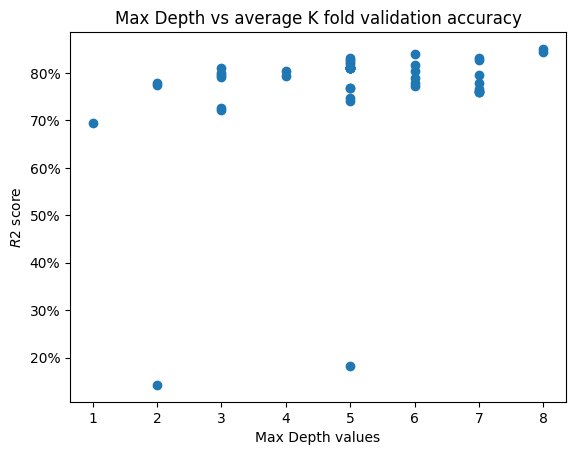

In [419]:
fig,axes = plt.subplots()
axes.scatter(cv_results['param_max_depth'],cv_results['mean_test_score']);
axes.set_title("Max Depth vs average K fold validation accuracy");
vals = axes.get_yticks();
axes.set_yticklabels(['{:,.0%}'.format(x) for x in vals]);
axes.set_ylabel('$R2$ score');
axes.set_xlabel('Max Depth values');

The higher the max depth, higher is the validation R2.

**Sub Sample**

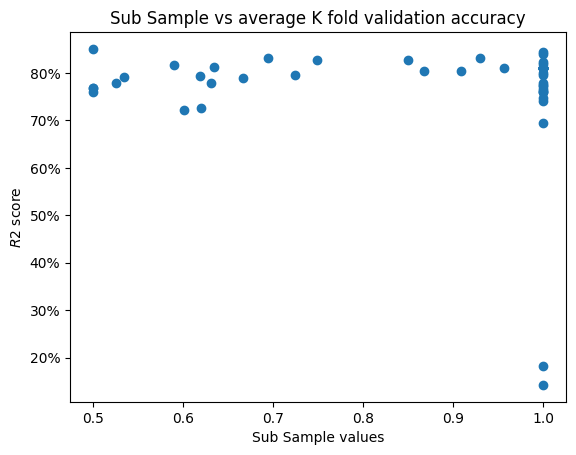

In [428]:
fig,axes = plt.subplots()
axes.scatter(cv_results['param_subsample'],cv_results['mean_test_score']);
axes.set_title("Sub Sample vs average K fold validation accuracy");
vals = axes.get_yticks();
axes.set_yticklabels(['{:,.0%}'.format(x) for x in vals]);
axes.set_ylabel('$R2$ score');
axes.set_xlabel('Sub Sample values');

There does not seem to be a huge correlation between sub sampling and R2 score. However,sub sampling paired with 
another hyperparameter can positively influence the R2 score.

**Num of Trees**

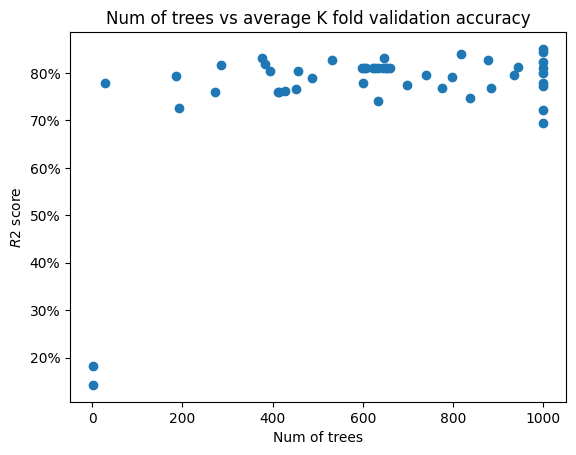

In [427]:
fig,axes = plt.subplots()
axes.scatter(cv_results['param_n_estimators'],cv_results['mean_test_score']);
axes.set_title("Num of trees vs average K fold validation accuracy");
vals = axes.get_yticks();
axes.set_yticklabels(['{:,.0%}'.format(x) for x in vals]);
axes.set_ylabel('$R2$ score');
axes.set_xlabel('Num of trees');

As the number of trees increase, we can see that validation R2 score increases as the number of trees increase.However, there is definitely influence of other factors such as eta as when eta is lower, the num of trees
will need to be higher to get a better model.

In [458]:
plot_df = cv_results[['params','param_colsample_bytree', 'param_eta', 'param_max_depth',\
       'param_n_estimators', 'param_subsample', 'mean_test_score','rank_test_score']].sort_values('rank_test_score')

In [459]:
plot_df.head(10)

,params,param_colsample_bytree,param_eta,param_max_depth,param_n_estimators,param_subsample,mean_test_score,rank_test_score
16,"{'colsample_bytree': 1.0, 'eta': 0.11985707181...",1.0,0.119857,8,1000,0.5,0.850484,1
15,"{'colsample_bytree': 0.9792789661291927, 'eta'...",0.979279,0.324329,8,1000,1.0,0.844864,2
14,"{'colsample_bytree': 1.0, 'eta': 0.63442165309...",1.0,0.634422,6,817,1.0,0.839017,3
48,"{'colsample_bytree': 1.0, 'eta': 0.58778858330...",1.0,0.587789,7,377,0.69506,0.832363,4
0,"{'colsample_bytree': 0.7654820824760737, 'eta'...",0.765482,0.679319,5,647,0.929372,0.831476,5
11,"{'colsample_bytree': 0.9068749937448564, 'eta'...",0.906875,0.729121,5,876,0.850161,0.827511,6
19,"{'colsample_bytree': 0.8277111339647238, 'eta'...",0.827711,0.607121,7,531,0.748497,0.826107,7
27,"{'colsample_bytree': 1.0, 'eta': 1.0, 'max_dep...",1.0,1.0,5,1000,1.0,0.823594,8
13,"{'colsample_bytree': 0.5, 'eta': 0.70275105746...",0.5,0.702751,5,384,1.0,0.818113,9
4,"{'colsample_bytree': 0.6162570141151325, 'eta'...",0.616257,0.250903,6,286,0.590548,0.816025,10


Now, we can see models of different complexities. While the top performer has the most complicated structure i.e. 
1000 trees and sampling all columns. Let us try to see if the least complex model amongst the top 10 i.e. model with 
rank 10 can do well on the test data set.

In [473]:
model_10 = XGBRegressor()
model_10.set_params(**dict(plot_df.iloc[9]['params']))
model_10.fit(X_train,y_train)
r2_score(y_test,model_10.predict(X_val))

0.8154439705593906

We still get a 81% R2 on the test dataset which is still alright.